# PCA Exploration of MMA Polymerization Data

This notebook performs **Principal Component Analysis (PCA)** on two datasets
used in the Polymer Chemistry Informed Neural Networks (PCINNs) project:

1. **Real experimental data:** 57 observations across 8 solution polymerization
   reactions of methyl methacrylate (MMA), loaded from `PMMAordered.xlsx`.
2. **Synthetic (theory) data:** ~2.5 million rows of simulated reaction
   trajectories generated by solving the kinetic ODEs (Morbidelli method),
   loaded from `Xdata.zip` and `Ydata.zip`.

The goal is to understand the intrinsic dimensionality and variance structure
of both the input space (reaction conditions) and the output space (conversion
and molecular weight moments), and to visualize how the tiny real dataset sits
within the much larger synthetic manifold.

**Reference:** Ballard, N. *Polymer Chemistry Informed Neural Networks.*
*Polym. Chem.*, 2024, **15**, 4580–4590.
DOI: [10.1039/D4PY00995A](https://doi.org/10.1039/D4PY00995A)

## 1. Dependencies & Environment Setup

In [19]:
# ---------------------------------------------------------------------------
# Dependencies: run once if not already installed.
# Pinned to the same versions used by the main PCINN notebook where possible.
# ---------------------------------------------------------------------------
%pip install numpy==2.4.2 pandas==2.2.3 matplotlib==3.10.8 openpyxl==3.1.5 scikit-learn

from __future__ import annotations

import warnings
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=FutureWarning)

# Reproducibility seed (matches the main notebook).
SEED: int = 42
np.random.seed(SEED)

# Matplotlib global defaults for publication-quality figures.
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.figsize": (10, 5),
})

print(f"NumPy {np.__version__}  |  pandas {pd.__version__}  |  scikit-learn "
      f"{__import__('sklearn').__version__}  |  matplotlib {plt.matplotlib.__version__}")

Note: you may need to restart the kernel to use updated packages.
NumPy 2.4.2  |  pandas 2.2.3  |  scikit-learn 1.8.0  |  matplotlib 3.10.8



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Feature & Target Definitions

Both datasets share the same semantic schema, even though the synthetic data
arrives pre-scaled while the real data is in physical units.

**5 inputs:** `[M]` (monomer conc.), `[S]` (solvent conc.), `[I]` (initiator conc.),
`temp` (temperature in K), `time` (reaction time in s).

**6 outputs:** `X` (conversion, 0–1), `Mn`, `Mw`, `Mz`, `Mz+1`, `Mv`
(molecular weight averages: stored as log₁₀ values in the training pipeline).

In [20]:
# ---------------------------------------------------------------------------
# Canonical column names shared across both datasets.
# The real data uses these exact column names from the Excel file; the
# synthetic data columns are positional (0-4 for X, 0-5 for Y) and are
# renamed to match during loading.
# ---------------------------------------------------------------------------

INPUT_COLS: list[str] = ["[M]", "[S]", "[I]", "temp", "time"]
"""The 5 input features (reaction conditions) for the PCINN."""

OUTPUT_COLS: list[str] = ["X", "log10_Mn", "log10_Mw", "log10_Mz", "log10_Mzplus1", "log10_Mv"]
"""The 6 output targets. Molecular weights are always in log10 space."""

# Human-readable labels for axis annotations and legends.
INPUT_LABELS: list[str] = ["[M] (mol/L)", "[S] (mol/L)", "[I] (mol/L)", "T (K)", "t (s)"]
OUTPUT_LABELS: list[str] = ["X (conversion)", "log₁₀(Mₙ)", "log₁₀(Mw)", "log₁₀(Mz)",
                             "log₁₀(Mz₊₁)", "log₁₀(Mv)"]

print(f"Inputs ({len(INPUT_COLS)}):  {INPUT_COLS}")
print(f"Outputs ({len(OUTPUT_COLS)}): {OUTPUT_COLS}")

Inputs (5):  ['[M]', '[S]', '[I]', 'temp', 'time']
Outputs (6): ['X', 'log10_Mn', 'log10_Mw', 'log10_Mz', 'log10_Mzplus1', 'log10_Mv']


## 3. Load Real Experimental Data

The real dataset lives in `PMMAordered.xlsx` and contains 57 observations
across 8 reactions (R1–R8). Each row is one time-sample from one reaction.

We extract the 5 inputs and 6 outputs, applying `log10` to the molecular
weight columns to match the PCINN training convention.

In [21]:
# ---------------------------------------------------------------------------
# Load and preprocess the real (experimental) dataset.
# ---------------------------------------------------------------------------

REAL_DATA_PATH: Path = Path("PMMAordered.xlsx")


def load_real_data(path: Path = REAL_DATA_PATH) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    Load the real MMA polymerization data from the Excel file.

    Returns
    -------
    X_real : pd.DataFrame
        Input features in physical units (unscaled), shape (N, 5).
    Y_real : pd.DataFrame
        Output targets with molecular weights in log10 space, shape (N, 6).
    reactions : pd.Series
        Reaction label (1–8) for each row, useful for coloring PCA plots.

    Raises
    ------
    FileNotFoundError
        If the Excel file is not found at the specified path.
    ValueError
        If expected columns are missing from the loaded DataFrame.
    """
    if not path.exists():
        raise FileNotFoundError(f"Real data file not found: {path}")

    df: pd.DataFrame = pd.read_excel(path)

    # Validate that expected columns are present.
    raw_input_cols: list[str] = ["[M]", "[S]", "[I]", "temp", "time"]
    raw_output_cols: list[str] = ["X", "Mn", "Mw", "Mz", "Mzplus1", "Mv"]
    missing: set[str] = set(raw_input_cols + raw_output_cols + ["Reaction"]) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")

    # Extract inputs (physical units, unscaled).
    X_real: pd.DataFrame = df[raw_input_cols].copy()
    X_real.columns = INPUT_COLS  # Already matches, but explicit for clarity.

    # Extract outputs, converting molecular weights to log10.
    # Conversion (X) stays as-is; Mn/Mw/Mz/Mzplus1/Mv get log10.
    mw_cols: list[str] = ["Mn", "Mw", "Mz", "Mzplus1", "Mv"]
    Y_real: pd.DataFrame = pd.DataFrame({
        OUTPUT_COLS[0]: df["X"].values,
        **{out_col: np.log10(df[raw_col].values.astype(np.float64))
           for out_col, raw_col in zip(OUTPUT_COLS[1:], mw_cols)}
    })

    reactions: pd.Series = df["Reaction"].copy()
    reactions.name = "Reaction"

    return X_real, Y_real, reactions


X_real, Y_real, reactions = load_real_data()

print(f"Real data loaded: {len(X_real)} observations across "
      f"{reactions.nunique()} reactions (R{reactions.min()}–R{reactions.max()}).")
print(f"\nInput features (physical units):")
display(X_real.describe().round(4))
print(f"\nOutput targets (X + log10 molecular weights):")
display(Y_real.describe().round(4))

Real data loaded: 57 observations across 8 reactions (R1–R8).

Input features (physical units):


,[M],[S],[I],temp,time
count,57.0000,57.0000,57.0000,57.0000,57.0000
mean,2.1813,7.8187,0.0305,345.2807,7933.3333
std,0.9530,0.9530,0.0125,7.5634,4847.0290
min,0.9080,6.6729,0.0123,333.0000,800.0000
25%,0.9327,6.6729,0.0146,343.0000,3600.0000
50%,1.9976,8.0024,0.0333,343.0000,7200.0000
75%,3.3271,9.0673,0.0368,353.0000,12600.0000
max,3.3271,9.0920,0.0498,353.0000,18000.0000



Output targets (X + log10 molecular weights):


,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
count,57.0000,57.0000,57.0000,57.0000,57.0000,57.0000
mean,0.5504,4.0573,4.3415,4.5676,4.6696,4.3061
std,0.2743,0.3739,0.3639,0.3702,0.3746,0.3636
min,0.0334,3.2087,3.6558,3.9072,4.0564,3.6088
25%,0.3477,3.8077,3.9814,4.1341,4.2554,3.9568
50%,0.5509,4.0965,4.3594,4.6289,4.6983,4.3246
75%,0.7893,4.2786,4.5517,4.7572,4.8968,4.5162
max,0.9900,4.7064,4.9467,5.1658,5.3302,4.9112


## 4. Load Synthetic (Theory) Data

The synthetic dataset was generated by the original paper's authors by solving
the Morbidelli-method ODEs for 10,000 randomly parameterized reactions, each
sampled at 250 linearly spaced time points (~2.5M rows total).

**Important notes from the author's email:**
- `Xdata.zip` contains the 5 inputs, **already min-max scaled** to [0, 1].
- `Ydata.zip` contains the outputs: conversion (unscaled) + molecular weight
  moments (already log₁₀-transformed).

The zip files are large (>100 MB compressed, multi-GB uncompressed) and
are tracked with **Git LFS** rather than committed directly. If they are not
present locally, this section is skipped gracefully.

In [ ]:
# ---------------------------------------------------------------------------
# Load the synthetic (kinetic-model-generated) dataset from zipped CSVs.
# These files are large and require Git LFS; we skip gracefully if absent.
#
# IMPORTANT DATA FORMAT NOTES (verified empirically):
#   - Xdata.zip contains inputs ALREADY in physical units ([M] in mol/L,
#     T in K, t in seconds, etc.) -- NOT min-max scaled to [0, 1].
#   - Ydata.zip column 0 is conversion (unscaled, 0-1).
#   - Ydata.zip columns 1-5 are molecular weights in RAW physical units
#     (e.g., Mn ~ 10,000-300,000), NOT log10-transformed.
#   We apply log10 to columns 1-5 here to match the real data convention.
# ---------------------------------------------------------------------------

SYNTH_X_PATH: Path = Path("Xdata.zip")
SYNTH_Y_PATH: Path = Path("Ydata.zip")


def load_synthetic_data(
    x_path: Path = SYNTH_X_PATH,
    y_path: Path = SYNTH_Y_PATH,
    subsample_frac: Optional[float] = 0.01,
) -> Optional[tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Load the synthetic dataset from zipped CSV files.

    Because the full dataset is ~2.5M rows and PCA on that many samples is
    computationally expensive (and unnecessary because the covariance estimate
    converges well before that), we optionally subsample.

    Parameters
    ----------
    x_path : Path
        Path to the zipped input CSV. Contains 5 input features already in
        physical units: [M] (mol/L), [S] (mol/L), [I] (mol/L), temp (K),
        time (s).
    y_path : Path
        Path to the zipped output CSV. Column 0 is conversion (0-1);
        columns 1-5 are raw molecular weights (Mn, Mw, Mz, Mz+1, Mv)
        which we log10-transform to match the real data convention.
    subsample_frac : float or None
        Fraction of rows to keep (0.01 = 1%). None means keep all rows.
        Even 1% (~25k rows) is more than sufficient for stable PCA.

    Returns
    -------
    tuple of (X_synth_phys, Y_synth) or None
        X_synth_phys : pd.DataFrame -- inputs in physical units, shape (N, 5).
        Y_synth      : pd.DataFrame -- outputs with conversion + log10(MW),
                        shape (N, 6).
        Returns None if zip files are not found.

    Raises
    ------
    ValueError
        If the loaded DataFrames have unexpected column counts or if any
        molecular weight value is non-positive (which would break log10).
    """
    if not x_path.exists() or not y_path.exists():
        print(f"⚠ Synthetic data not found ({x_path}, {y_path}).")
        print("  Place Xdata.zip and Ydata.zip in the notebook directory and re-run.")
        return None

    print(f"Loading synthetic inputs from {x_path} ...")
    dfX_raw: pd.DataFrame = pd.read_csv(x_path)
    print(f"Loading synthetic outputs from {y_path} ...")
    dfY_raw: pd.DataFrame = pd.read_csv(y_path)

    print(f"  Raw shapes: X={dfX_raw.shape}, Y={dfY_raw.shape}")

    # Validate column counts.
    if dfX_raw.shape[1] < 5:
        raise ValueError(f"Expected >= 5 input columns, got {dfX_raw.shape[1]}")
    if dfY_raw.shape[1] < 6:
        raise ValueError(f"Expected >= 6 output columns, got {dfY_raw.shape[1]}")

    # Take the first 5 columns as inputs (already in physical units).
    X_phys_arr: np.ndarray = dfX_raw.iloc[:, :5].values.astype(np.float64)
    # Take the first 6 columns as outputs (conversion + raw MW).
    Y_raw_arr: np.ndarray = dfY_raw.iloc[:, :6].values.astype(np.float64)

    # Subsample for computational tractability.
    n_total: int = X_phys_arr.shape[0]
    if subsample_frac is not None and 0 < subsample_frac < 1.0:
        rng = np.random.default_rng(SEED)
        n_keep: int = max(1, int(n_total * subsample_frac))
        idx: np.ndarray = rng.choice(n_total, size=n_keep, replace=False)
        idx.sort()  # Preserve original ordering for reproducibility.
        X_phys_arr = X_phys_arr[idx]
        Y_raw_arr = Y_raw_arr[idx]
        print(f"  Subsampled {subsample_frac:.1%}: {n_total} → {len(idx)} rows.")

    # The raw CSV stores Mn, Mw, Mz, Mz+1, Mv in physical units (daltons).
    # The PCINN pipeline and real data both use log10-transformed values.
    mw_cols_raw: np.ndarray = Y_raw_arr[:, 1:]  # columns 1-5
    if np.any(mw_cols_raw <= 0):
        n_bad: int = int(np.sum(mw_cols_raw <= 0))
        raise ValueError(
            f"{n_bad} non-positive MW values found; cannot apply log10. "
            "Check that Ydata.zip columns 1-5 are molecular weights."
        )
    Y_arr: np.ndarray = np.column_stack([
        Y_raw_arr[:, 0],            # conversion -- keep as-is
        np.log10(Y_raw_arr[:, 1:])  # MW moments -- transform to log10
    ])
    print(f"  Applied log10 to MW columns (1-5). "
          f"Mn range: {Y_raw_arr[:, 1].min():.0f}–{Y_raw_arr[:, 1].max():.0f} "
          f"→ {Y_arr[:, 1].min():.3f}–{Y_arr[:, 1].max():.3f} (log10).")

    # Build DataFrames with canonical column names.
    # NOTE: X is already in physical units -- no un-scaling needed.
    X_synth_phys: pd.DataFrame = pd.DataFrame(X_phys_arr, columns=INPUT_COLS)
    Y_synth: pd.DataFrame = pd.DataFrame(Y_arr, columns=OUTPUT_COLS)

    return X_synth_phys, Y_synth


synth_result = load_synthetic_data()

HAVE_SYNTH: bool = synth_result is not None
if HAVE_SYNTH:
    X_synth_phys, Y_synth = synth_result
    print(f"\nSynthetic data loaded: {len(X_synth_phys)} rows (subsampled).")
    print(f"\nInputs (physical units):")
    display(X_synth_phys.describe().round(4))
    print(f"\nOutputs (X + log10 MW):")
    display(Y_synth.describe().round(4))
else:
    print("\nProceeding with real data only.")


Loading synthetic inputs from Xdata.zip ...
Loading synthetic outputs from Ydata.zip ...
  Raw shapes: X=(2489166, 5), Y=(2489166, 37)
  Subsampled 1.0%: 2489166 → 24891 rows.
  Applied log10 to MW columns (1-5). Mn range: 595–313372 → 2.774–5.496 (log10).

Synthetic data loaded: 24891 rows (subsampled).

Inputs (physical units):


,[M],[S],[I],temp,time
count,24891.0000,24891.0000,24891.0000,24891.0000,24891.0000
mean,2.7668,7.2332,0.0518,343.1402,9115.6405
std,1.3025,1.3025,0.0275,11.6218,7903.8317
min,0.5002,5.0002,0.0050,323.0043,2.8135
25%,1.6455,6.1112,0.0280,333.0366,2603.8485
50%,2.7638,7.2362,0.0513,343.1752,6866.1673
75%,3.8888,8.3545,0.0760,353.3650,13941.8251
max,4.9998,9.4998,0.1000,362.9998,35767.9725



Outputs (X + log10 MW):


,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
count,24891.0000,24891.0000,24891.0000,24891.0000,24891.0000,24891.0000
mean,0.5978,4.2272,4.6724,4.9705,5.2082,4.6224
std,0.3299,0.4790,0.4317,0.4109,0.4011,0.4361
min,0.0003,2.7743,3.2910,3.6632,3.9312,3.2261
25%,0.2976,3.8845,4.3804,4.6991,4.9448,4.3271
50%,0.6568,4.2444,4.6768,4.9748,5.2141,4.6272
75%,0.9215,4.5864,4.9885,5.2686,5.5002,4.9419
max,0.9990,5.4961,5.8795,6.1292,6.3048,5.8368


## 5. Preprocessing for PCA

PCA is sensitive to feature scales, so we standardize (zero mean, unit variance)
before fitting. We do this separately for inputs and outputs, and for each
dataset (real vs. synthetic).

For the **overlay analysis** (projecting real data into the synthetic PCA space),
we fit the scaler on the synthetic data and transform the real data using
that same scaler. This lets us see where the 57 experimental points land in
the synthetic manifold.

In [23]:
# ---------------------------------------------------------------------------
# Standardize features for PCA.
# We prepare several variants:
#   (a) Real data standardized on its own statistics (standalone PCA).
#   (b) Synthetic data standardized on its own statistics (standalone PCA).
#   (c) Real data standardized using SYNTHETIC statistics (overlay projection).
# ---------------------------------------------------------------------------


def standardize(
    df: pd.DataFrame,
    scaler: Optional[StandardScaler] = None,
) -> tuple[np.ndarray, StandardScaler]:
    """
    Standardize a DataFrame to zero-mean, unit-variance.

    Parameters
    ----------
    df : pd.DataFrame
        Data to standardize.
    scaler : StandardScaler or None
        If provided, use this (already-fit) scaler to transform. If None,
        fit a new scaler on ``df`` and return it.

    Returns
    -------
    arr : np.ndarray
        Standardized array, same shape as ``df``.
    scaler : StandardScaler
        The scaler used (fit or pre-fit).
    """
    if scaler is None:
        scaler = StandardScaler()
        arr: np.ndarray = scaler.fit_transform(df.values)
    else:
        arr = scaler.transform(df.values)
    return arr, scaler


# --- (a) Real data, self-standardized ---
X_real_std, scaler_Xreal = standardize(X_real)
Y_real_std, scaler_Yreal = standardize(Y_real)

print(f"Real inputs  standardized: shape {X_real_std.shape}, "
      f"mean ≈ {X_real_std.mean(axis=0).round(6)}, std ≈ {X_real_std.std(axis=0).round(4)}")
print(f"Real outputs standardized: shape {Y_real_std.shape}, "
      f"mean ≈ {Y_real_std.mean(axis=0).round(6)}, std ≈ {Y_real_std.std(axis=0).round(4)}")

# --- (b) Synthetic data, self-standardized ---
if HAVE_SYNTH:
    # We use the PHYSICAL-unit version so the PCA is in the same feature
    # space as the real data (not in the [0,1] scaled space).
    X_synth_std, scaler_Xsynth = standardize(X_synth_phys)
    Y_synth_std, scaler_Ysynth = standardize(Y_synth)

    print(f"\nSynth inputs  standardized: shape {X_synth_std.shape}")
    print(f"Synth outputs standardized: shape {Y_synth_std.shape}")

    # --- (c) Real data projected into synthetic scaler ---
    X_real_in_synth_space, _ = standardize(X_real, scaler=scaler_Xsynth)
    Y_real_in_synth_space, _ = standardize(Y_real, scaler=scaler_Ysynth)
    print(f"\nReal data re-standardized using synthetic statistics (for overlay).")

Real inputs  standardized: shape (57, 5), mean ≈ [ 0.  0.  0. -0.  0.], std ≈ [1. 1. 1. 1. 1.]
Real outputs standardized: shape (57, 6), mean ≈ [ 0. -0.  0.  0. -0.  0.], std ≈ [1. 1. 1. 1. 1. 1.]

Synth inputs  standardized: shape (24891, 5)
Synth outputs standardized: shape (24891, 6)

Real data re-standardized using synthetic statistics (for overlay).


## 6. PCA on Real Experimental Data

With only 57 observations in 5D input space and 6D output space, we expect
PCA to reveal the effective dimensionality of the experimental design.
The 8 reactions use only 3 temperatures (60, 70, 80 °C) and a handful of
distinct monomer/initiator loadings, so the input space is likely very
low-rank.

In [24]:
# ---------------------------------------------------------------------------
# PCA on real experimental INPUTS (5 features).
# ---------------------------------------------------------------------------


def run_pca(
    data: np.ndarray,
    feature_names: list[str],
    title: str,
    n_components: Optional[int] = None,
) -> PCA:
    """
    Fit PCA and print a summary of explained variance and loadings.

    Parameters
    ----------
    data : np.ndarray
        Standardized data, shape (n_samples, n_features).
    feature_names : list[str]
        Names of the original features, for labeling loadings.
    title : str
        Descriptive title printed above the summary.
    n_components : int or None
        Number of components to retain. None = all.

    Returns
    -------
    pca : PCA
        Fitted PCA object.
    """
    pca = PCA(n_components=n_components, random_state=SEED)
    pca.fit(data)

    print(f"{'=' * 60}")
    print(f"  {title}")
    print(f"  Samples: {data.shape[0]}  |  Features: {data.shape[1]}")
    print(f"{'=' * 60}")

    cumvar: np.ndarray = np.cumsum(pca.explained_variance_ratio_)
    for i, (var, cum) in enumerate(zip(pca.explained_variance_ratio_, cumvar)):
        print(f"  PC{i+1:>2d}:  {var:7.2%} variance  |  cumulative: {cum:7.2%}")

    # Print loadings as a DataFrame for clarity.
    loadings: pd.DataFrame = pd.DataFrame(
        pca.components_,
        columns=feature_names,
        index=[f"PC{i+1}" for i in range(pca.n_components_)],
    )
    print(f"\n  Loadings (component × feature):")
    display(loadings.round(4))
    print()

    return pca


pca_real_X = run_pca(X_real_std, INPUT_COLS, "PCA — Real Inputs (5D)")

  PCA — Real Inputs (5D)
  Samples: 57  |  Features: 5
  PC 1:   46.98% variance  |  cumulative:  46.98%
  PC 2:   25.98% variance  |  cumulative:  72.96%
  PC 3:   17.35% variance  |  cumulative:  90.31%
  PC 4:    9.69% variance  |  cumulative: 100.00%
  PC 5:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,[M],[S],[I],temp,time
PC1,-0.6339,0.6339,0.4175,0.1151,0.0940
PC2,-0.0313,0.0313,-0.4179,0.7268,0.5432
PC3,0.1418,-0.1418,0.3553,-0.3977,0.8218
PC4,0.2777,-0.2777,0.7244,0.5480,-0.1439
PC5,0.7071,0.7071,0.0000,0.0000,-0.0000


### Analysis - Real Input PCA

The input space has **4 effective dimensions** out of 5 nominal features,
reaching exactly 100.00% at PC4 while PC5 captures 0.00%. This is a direct
consequence of the physical constraint **[S] = 10 − [M]**: since solvent
concentration is perfectly determined by monomer concentration, these two
features are perfectly co-linear. PC5's loadings confirm this: both [M] and
[S] load at exactly 0.7071 (= 1/√2), and all other features have zero loading.
This is PCA capturing the redundant dimension and assigning it zero variance.

The variance distribution across the remaining 4 components is **uneven**,
suggesting the experimental design is not uniformly space-filling:

- **PC1 (47.0%):** The monomer/solvent concentration axis. Loadings:
  [M] = −0.63, [S] = +0.63, with a moderate contribution from [I] = +0.42.
  This is the dominant source of variation because the 8 reactions span a wide
  range of monomer loadings (10 g to 50 g → [M] from 0.91 to 3.33 mol/L).

- **PC2 (26.0%):** The temperature/time axis. Loadings: temp = +0.73,
  time = +0.54. This captures the fact that hotter reactions (80 °C) tend to
  be sampled at different time points than cooler reactions (60 °C).

- **PC3 (17.4%):** Time-dominated. Loading: time = +0.82, with a negative
  temperature contribution (−0.40). This separates early-time vs. late-time
  samples within each reaction.

- **PC4 (9.7%):** Initiator concentration. Loading: [I] = +0.72,
  temp = +0.55. This residual component captures the remaining variation
  in initiator dosing that wasn't absorbed by PC1.

**Key takeaway:** 3 PCs suffice for 90.3% of input variance. The effective
dimensionality of the real experimental design is ~3, consistent with the
paper's use of only 3 temperature levels and a handful of distinct
monomer/initiator combinations.

In [25]:
# ---------------------------------------------------------------------------
# PCA on real experimental OUTPUTS (6 features).
# ---------------------------------------------------------------------------

pca_real_Y = run_pca(Y_real_std, OUTPUT_COLS, "PCA — Real Outputs (6D)")

  PCA — Real Outputs (6D)
  Samples: 57  |  Features: 6
  PC 1:   85.67% variance  |  cumulative:  85.67%
  PC 2:   13.29% variance  |  cumulative:  98.97%
  PC 3:    0.71% variance  |  cumulative:  99.68%
  PC 4:    0.32% variance  |  cumulative:  99.99%
  PC 5:    0.01% variance  |  cumulative: 100.00%
  PC 6:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
PC1,-0.2184,0.4369,0.4395,0.4332,0.4328,0.4396
PC2,0.9728,0.0440,0.0932,0.1526,0.1094,0.0881
PC3,-0.0121,-0.4458,0.0305,-0.3880,0.8060,-0.0044
PC4,-0.0757,-0.6749,-0.0017,0.7309,-0.0229,-0.0629
PC5,0.0101,-0.3897,0.5286,-0.3214,-0.3871,0.5617
PC6,0.0002,0.0311,0.7196,-0.0302,-0.0284,-0.6924


### Analysis - Real Output PCA

The output space is remarkably low-dimensional: **2 PCs capture 98.97%** of
all output variance. This is a striking result given that there are 6 output
columns.

- **PC1 (85.7%):** The "overall molecular weight" component. All five
  log₁₀(MW) features load nearly identically at ≈ +0.43, while conversion
  loads negatively at −0.22. This means that Mn, Mw, Mz, Mz+1, and Mv
  move almost in lockstep: if one goes up, they all go up. Physically, this
  makes sense: all five moments are derived from the same underlying molecular
  weight distribution (MWD), and in a relatively homogeneous free-radical
  polymerization the shape of the MWD doesn't change drastically, so all
  averages shift together.

- **PC2 (13.3%):** Conversion, and almost nothing else. Loading: X = +0.97,
  with all MW loadings below 0.15. This component captures the time evolution
  within each reaction: conversion increases as the reaction proceeds, but
  the molecular weight averages (which are intensive properties) stay relatively
  stable after an initial transient.

- **PC3–PC6 (combined 1.03%):** Residual MWD shape variation. These capture
  tiny deviations in the *relative* relationships between the moments (e.g.,
  polydispersity changes). Their near-zero variance confirms that the MWD shape
  is effectively constant across these experiments.

**Key takeaway:** The 6 PCINN outputs are practically a 2D manifold:
one "molecular weight scale" dimension and one "conversion progress" dimension.
This very low intrinsic dimensionality explains why even a small neural network
(5→128→64→6) can learn the output mapping: there are only ~2 independent
things to predict.

### 6.1 Scree Plots - Real Data

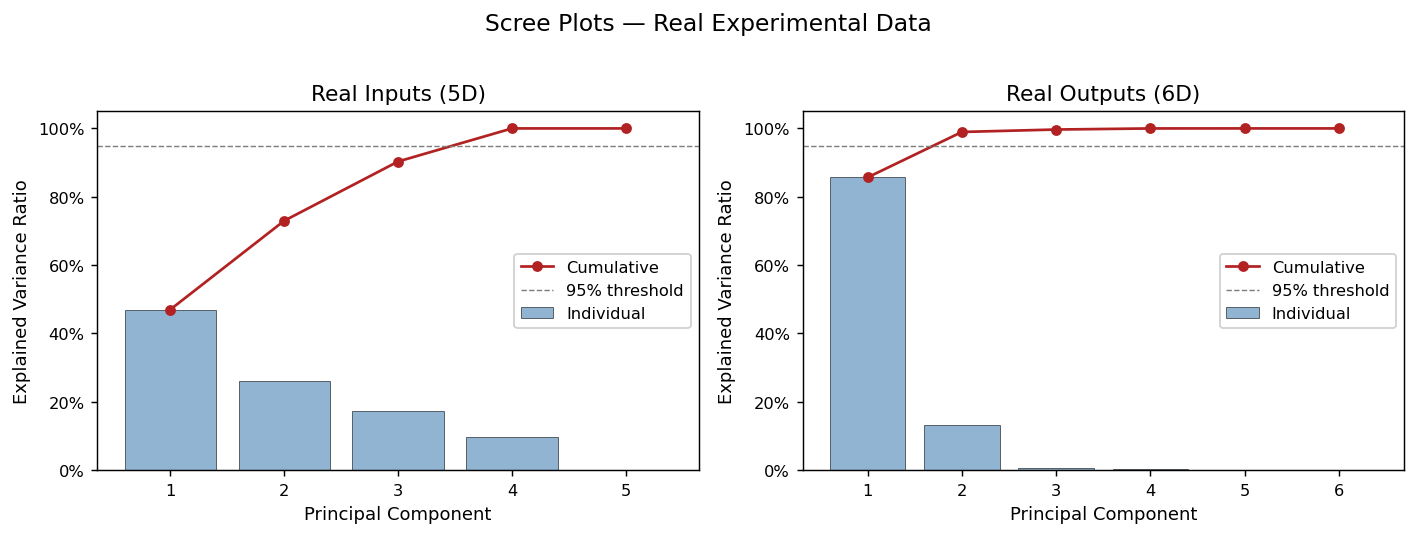

In [26]:
# ---------------------------------------------------------------------------
# Scree plots: explained variance per component for real data inputs & outputs.
# ---------------------------------------------------------------------------


def plot_scree(
    pca_obj: PCA,
    title: str,
    ax: Optional[plt.Axes] = None,
) -> None:
    """
    Plot both individual and cumulative explained variance for a fitted PCA.

    Parameters
    ----------
    pca_obj : PCA
        A fitted scikit-learn PCA object.
    title : str
        Title for the subplot.
    ax : Axes or None
        Matplotlib axes to draw on. Creates a new figure if None.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 3.5))

    n: int = pca_obj.n_components_
    x_ticks: np.ndarray = np.arange(1, n + 1)
    var: np.ndarray = pca_obj.explained_variance_ratio_
    cumvar: np.ndarray = np.cumsum(var)

    # Bar chart for individual variance.
    ax.bar(x_ticks, var, alpha=0.6, label="Individual", color="steelblue", edgecolor="k", lw=0.5)
    # Line for cumulative.
    ax.plot(x_ticks, cumvar, "o-", color="firebrick", markersize=5, label="Cumulative")

    # 95% threshold line.
    ax.axhline(0.95, ls="--", color="gray", lw=0.8, label="95% threshold")

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_title(title)
    ax.set_xticks(x_ticks)
    ax.set_ylim(0, 1.05)
    ax.legend(loc="center right", framealpha=0.9)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))


fig, axes = plt.subplots(1, 2, figsize=(11, 4))
plot_scree(pca_real_X, "Real Inputs (5D)", ax=axes[0])
plot_scree(pca_real_Y, "Real Outputs (6D)", ax=axes[1])
fig.suptitle("Scree Plots — Real Experimental Data", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

### Scree Plot Interpretation - Real Data

**Left (Inputs):** The gradual decay across PC1–PC4 with no sharp "elbow"
indicates that the input variation is spread across multiple factors, none of
which overwhelmingly dominates. The 95% threshold is crossed between PC3 and
PC4, confirming an intrinsic dimensionality of ~3–4.

**Right (Outputs):** There is a very sharp elbow after PC1, which alone
captures 85.7%. The 95% threshold is already surpassed by PC2 (cumulative
98.97%). Everything beyond PC2 is essentially noise or negligible MWD shape
variation. This extreme concentration of variance in the first component is
the hallmark of highly correlated features, as expected from five molecular
weight moments of the same distribution.

### 6.2 PC1 vs PC2 Scatter - Real Data

Coloring by reaction ID reveals how the 8 distinct experimental conditions
cluster in the reduced space.

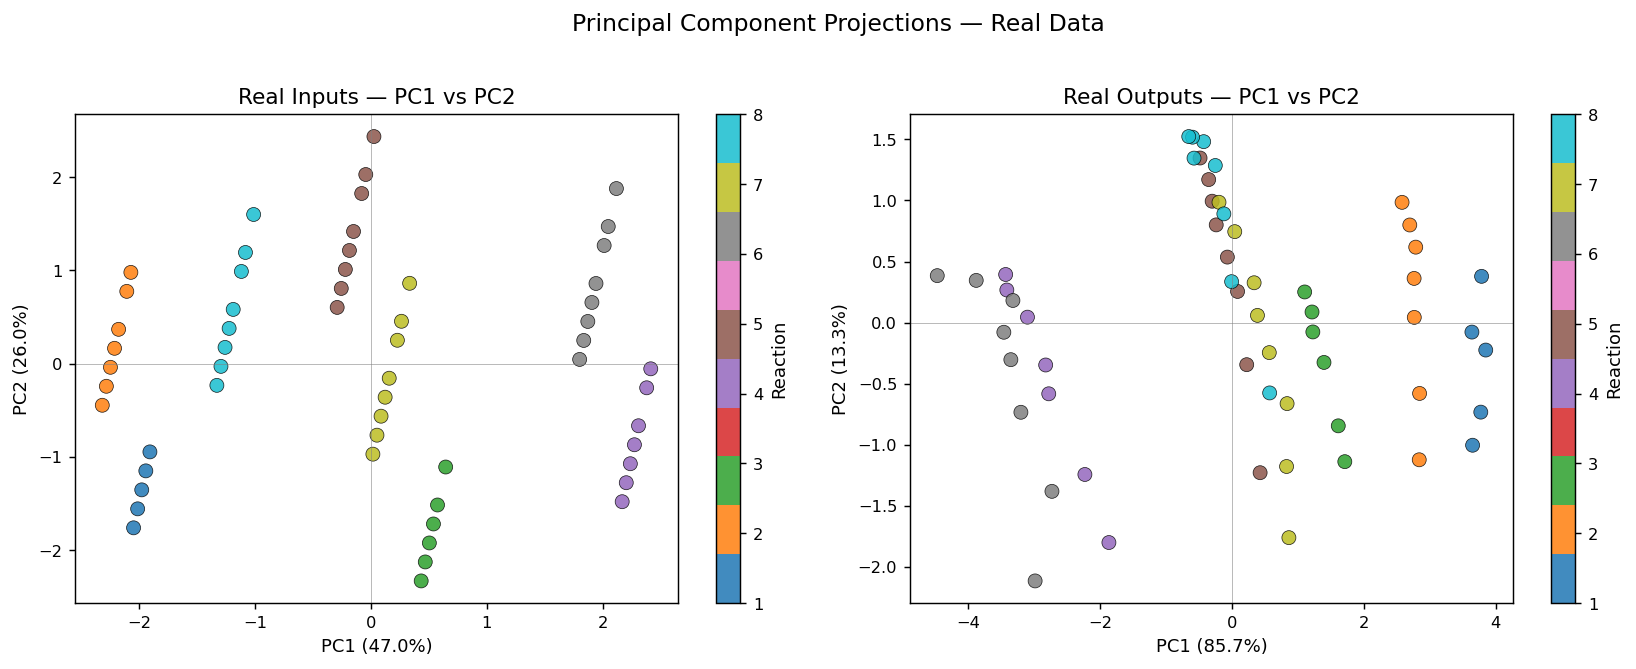

In [27]:
# ---------------------------------------------------------------------------
# 2D scatter plots of PC1 vs PC2 for real data, colored by reaction.
# ---------------------------------------------------------------------------


def scatter_pc1_pc2(
    data_std: np.ndarray,
    pca_obj: PCA,
    color_labels: np.ndarray,
    title: str,
    ax: Optional[plt.Axes] = None,
    cmap: str = "tab10",
    colorbar_label: str = "Reaction",
) -> None:
    """
    Scatter plot of the first two principal components.

    Parameters
    ----------
    data_std : np.ndarray
        Standardized data, shape (n, d).
    pca_obj : PCA
        Fitted PCA (must have >= 2 components).
    color_labels : np.ndarray
        Numeric labels for coloring each point.
    title : str
        Subplot title.
    ax : Axes or None
        Target axes.
    cmap : str
        Matplotlib colormap name.
    colorbar_label : str
        Label for the colorbar.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))

    scores: np.ndarray = pca_obj.transform(data_std)
    var: np.ndarray = pca_obj.explained_variance_ratio_

    sc = ax.scatter(
        scores[:, 0], scores[:, 1],
        c=color_labels, cmap=cmap, edgecolors="k", linewidths=0.4,
        s=60, alpha=0.85,
    )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(colorbar_label)

    ax.set_xlabel(f"PC1 ({var[0]:.1%})")
    ax.set_ylabel(f"PC2 ({var[1]:.1%})")
    ax.set_title(title)
    ax.axhline(0, ls="-", lw=0.3, color="gray")
    ax.axvline(0, ls="-", lw=0.3, color="gray")


fig, axes = plt.subplots(1, 2, figsize=(13, 5))
scatter_pc1_pc2(X_real_std, pca_real_X, reactions.values,
                "Real Inputs — PC1 vs PC2", ax=axes[0])
scatter_pc1_pc2(Y_real_std, pca_real_Y, reactions.values,
                "Real Outputs — PC1 vs PC2", ax=axes[1])
fig.suptitle("Principal Component Projections — Real Data", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

### PC1 vs PC2 Scatter - Real Data Interpretation

**Left (Inputs):** The 8 reactions separate cleanly into distinct groups
along the PC1 axis. Each reaction forms a roughly horizontal streak (spread
along PC2), reflecting the fact that all time-points within a single
reaction share the same [M], [I], and temperature, only time varies. The
horizontal (PC1) separation between reaction groups corresponds to differences
in monomer loading, while the vertical (PC2) spread captures temperature and
time differences. Notable features:

- Reactions 1, 2, 7, 8 (high [M] ≈ 50 g) cluster on the left (negative PC1).
- Reactions 4, 6 (low [M] ≈ 10 g) cluster on the right (positive PC1).
- Reactions 3, 5 (medium [M] ≈ 25 g) sit in the middle.
- The vertical spread within each group tracks temperature: 80 °C reactions
  (R5, R6, R8) tend to sit higher on PC2 than 60 °C reactions (R1, R3).

**Right (Outputs):** The output PC1 axis (85.7% variance) strongly separates
reactions by their molecular weight scale. Points spread from left (low MW,
corresponding to low [M] or high conversion) to right (high MW). The vertical
PC2 axis is primarily conversion progress: within each reaction, points move
vertically as the reaction proceeds. The early-time samples (low conversion)
cluster near the top, while late-time samples (high conversion) sit near
the bottom.

### 6.3 Biplots - Real Data

Biplots overlay the loading vectors (feature contributions) on top of the
score scatter. Longer arrows indicate features that contribute more to that
component; the angle between arrows indicates correlation between features.

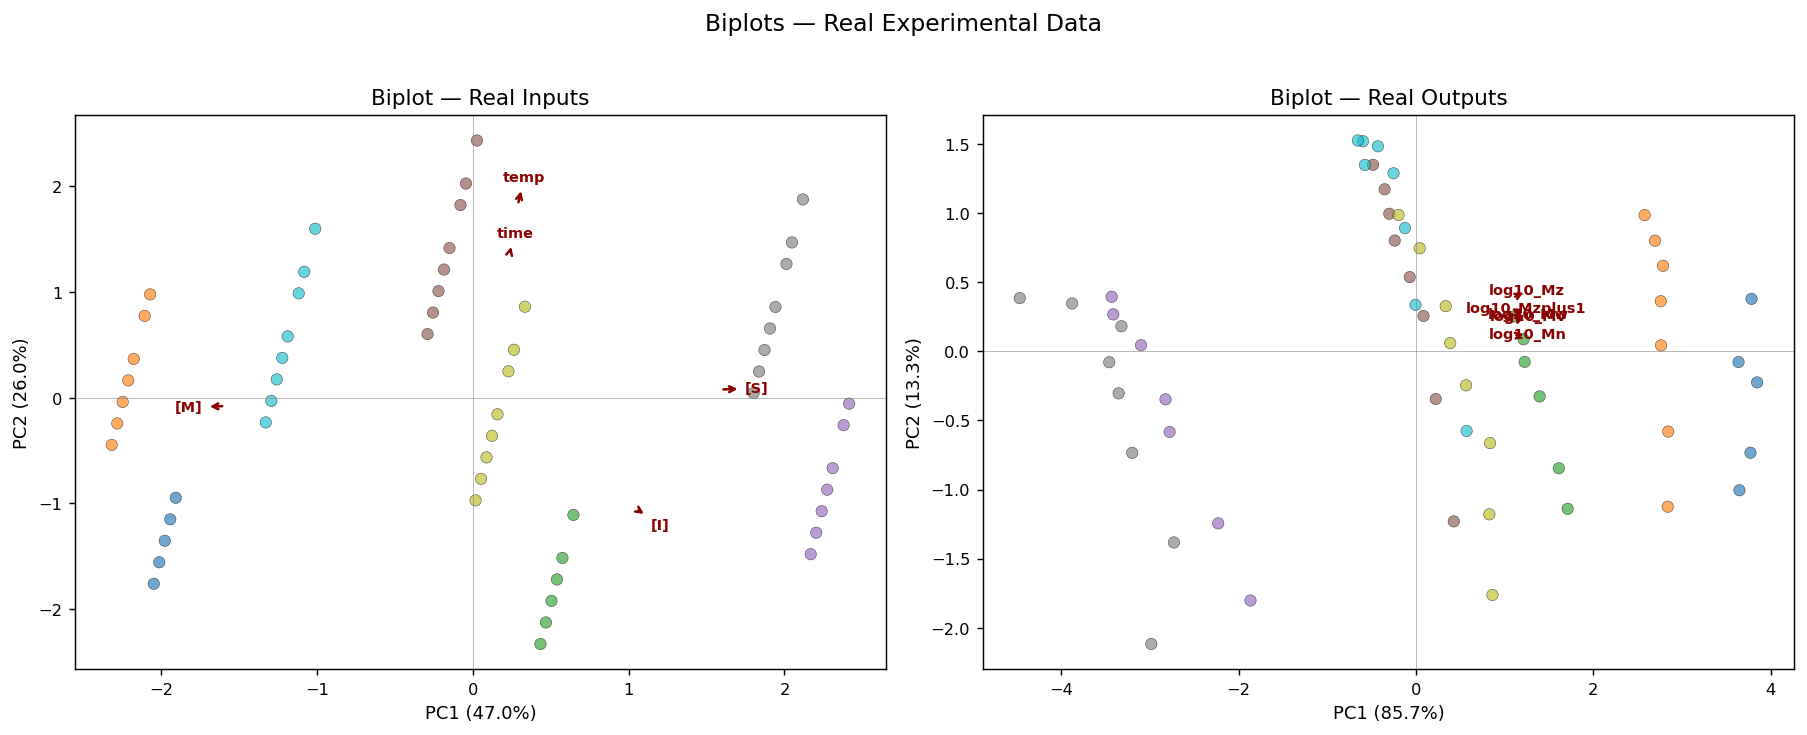

In [28]:
# ---------------------------------------------------------------------------
# Biplot: scores + loading vectors overlaid.
# ---------------------------------------------------------------------------


def biplot(
    data_std: np.ndarray,
    pca_obj: PCA,
    feature_names: list[str],
    color_labels: np.ndarray,
    title: str,
    ax: Optional[plt.Axes] = None,
    arrow_scale: float = 2.5,
) -> None:
    """
    Draw a biplot showing both sample scores and feature loading vectors.

    Parameters
    ----------
    data_std : np.ndarray
        Standardized data.
    pca_obj : PCA
        Fitted PCA.
    feature_names : list[str]
        Original feature names for arrow labels.
    color_labels : np.ndarray
        Per-point color values.
    title : str
        Plot title.
    ax : Axes or None
        Target axes.
    arrow_scale : float
        Multiplier for arrow length (purely visual).
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 6))

    scores: np.ndarray = pca_obj.transform(data_std)
    var: np.ndarray = pca_obj.explained_variance_ratio_

    # Scatter the scores.
    ax.scatter(
        scores[:, 0], scores[:, 1],
        c=color_labels, cmap="tab10", edgecolors="k", linewidths=0.3,
        s=40, alpha=0.65, zorder=2,
    )

    # Overlay loading vectors as arrows.
    loadings: np.ndarray = pca_obj.components_[:2, :]  # (2, n_features)
    for j, name in enumerate(feature_names):
        dx: float = loadings[0, j] * arrow_scale
        dy: float = loadings[1, j] * arrow_scale
        ax.annotate(
            name,
            xy=(dx, dy),
            xytext=(dx * 1.15, dy * 1.15),
            fontsize=8, fontweight="bold", color="darkred",
            arrowprops=dict(arrowstyle="<-", color="darkred", lw=1.4),
            ha="center", va="center",
        )

    ax.set_xlabel(f"PC1 ({var[0]:.1%})")
    ax.set_ylabel(f"PC2 ({var[1]:.1%})")
    ax.set_title(title)
    ax.axhline(0, ls="-", lw=0.3, color="gray")
    ax.axvline(0, ls="-", lw=0.3, color="gray")


fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
biplot(X_real_std, pca_real_X, INPUT_COLS, reactions.values,
       "Biplot — Real Inputs", ax=axes[0])
biplot(Y_real_std, pca_real_Y, OUTPUT_COLS, reactions.values,
       "Biplot — Real Outputs", ax=axes[1])
fig.suptitle("Biplots — Real Experimental Data", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

### Biplot Interpretation - Real Data

**Left (Input Biplot):** The biplot arrows reveal the physical meaning of
the principal components. The [M] and [S] arrows point in perfectly opposite
directions along PC1 (confirming the [S] = 10−[M] constraint), and they are
the longest arrows, confirming PC1 is the monomer concentration axis. The
`temp` arrow points nearly straight up (toward positive PC2), confirming
PC2 captures temperature variation. The `time` arrow is shorter and angled
between PC2 and PC3, indicating that reaction time is distributed across
multiple components. The `[I]` arrow points into the lower-right quadrant,
nearly orthogonal to temp, initiator and temperature vary somewhat independently
in this experimental design.

**Right (Output Biplot):** All five MW moment arrows overlap almost perfectly,
pointing together toward positive PC1. This is the visual manifestation of
their near-perfect correlation (r = 0.96–0.99, as shown later in the
heatmap). The conversion arrow (X) is not visible because it points nearly
straight up along PC2, orthogonal to the MW cluster, which confirms that
conversion and molecular weight are largely independent dimensions in output
space.

## 7. PCA on Synthetic (Theory) Data

This section only runs if `Xdata.zip` and `Ydata.zip` are present. The
synthetic data spans the full physical parameter space sampled by the kinetic
model (T ∈ [50, 90] °C, [M] ∈ [0.5, 5] mol/L, [I] ∈ [0.005, 0.1] mol/L,
t ∈ [300, 36000] s), which is much broader than the 8 real experiments.

In [29]:
# ---------------------------------------------------------------------------
# PCA on synthetic data (inputs and outputs).
# Skipped gracefully if synthetic data is absent.
# ---------------------------------------------------------------------------

if HAVE_SYNTH:
    pca_synth_X = run_pca(X_synth_std, INPUT_COLS, "PCA — Synthetic Inputs (5D)")
    pca_synth_Y = run_pca(Y_synth_std, OUTPUT_COLS, "PCA — Synthetic Outputs (6D)")
else:
    print("Skipped — synthetic data not available.")

  PCA — Synthetic Inputs (5D)
  Samples: 24891  |  Features: 5
  PC 1:   40.03% variance  |  cumulative:  40.03%
  PC 2:   20.10% variance  |  cumulative:  60.13%
  PC 3:   20.00% variance  |  cumulative:  80.13%
  PC 4:   19.87% variance  |  cumulative: 100.00%
  PC 5:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,[M],[S],[I],temp,time
PC1,-0.7066,0.7066,0.0302,0.0127,-0.0158
PC2,-0.0236,0.0236,-0.6742,-0.1215,0.7277
PC3,0.0050,-0.0050,-0.1810,0.9834,-0.0032
PC4,0.0088,-0.0088,0.7154,0.1338,0.6857
PC5,0.7071,0.7071,0.0000,0.0000,0.0000



  PCA — Synthetic Outputs (6D)
  Samples: 24891  |  Features: 6
  PC 1:   89.28% variance  |  cumulative:  89.28%
  PC 2:   10.43% variance  |  cumulative:  99.71%
  PC 3:    0.28% variance  |  cumulative:  99.99%
  PC 4:    0.01% variance  |  cumulative: 100.00%
  PC 5:    0.00% variance  |  cumulative: 100.00%
  PC 6:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
PC1,-0.2889,0.4295,0.4302,0.4266,0.4238,0.4306
PC2,0.9396,-0.0126,0.1169,0.1925,0.2361,0.1030
PC3,0.1794,0.8313,-0.0252,-0.3278,-0.4084,0.0431
PC4,-0.0398,0.3434,-0.4837,0.0890,0.5823,-0.5473
PC5,0.0059,0.0790,-0.0493,0.7967,-0.5064,-0.3166
PC6,0.0001,0.0102,0.7512,-0.1757,0.0486,-0.6344


### Analysis - Synthetic Input PCA vs. Real Input PCA

The synthetic input PCA reveals critical differences from the real data:

**PC1 is identical in meaning:** [M]/[S] anti-correlation dominates
(loadings: [M] = −0.71, [S] = +0.71), and PC5 = 0% again captures the
[S] = 10−[M] redundancy. This structural feature is inherent to the chemistry.

**But the variance distribution is far more uniform.** In the synthetic data,
PC2–PC4 each capture ≈ 20% of variance (20.1%, 20.0%, 19.9%), compared to the
real data's uneven split (26.0%, 17.4%, 9.7%). This is because the synthetic
data samples [I], T, and t from independent uniform distributions over their
full physical ranges, whereas the 8 real experiments use a constrained,
non-uniform design (only 3 temperature levels, correlated monomer/initiator
loadings).

The near-equal PC2–PC4 variance in synthetic data indicates that
initiator concentration, temperature, and time each contribute roughly equal
amounts of variation when sampled uniformly: there is no single dominant
input feature beyond the [M]/[S] pair.

**Synthetic Output PCA vs. Real:**
Now that the synthetic MW columns are correctly log₁₀-transformed (matching
the real data's convention), the PCA structure is strikingly similar:

| Component | Real Variance | Synthetic Variance |
|-----------|:------------:|:------------------:|
| PC1       | 85.67%       | 89.28%             |
| PC2       | 13.29%       | 10.43%             |
| PC3–PC6   |  1.03%       |  0.29%             |

Both datasets are overwhelmingly 2-dimensional in output space: one molecular
weight axis (PC1) and one conversion axis (PC2). The loadings are nearly
identical: PC1 loads all MW moments at ≈ 0.43, PC2 loads conversion at
0.97 (real) / 0.94 (synthetic). This convergence across independently
collected datasets confirms the 2D output structure is a fundamental
property of free-radical polymerization, not an artifact of the
experimental design or data processing.

One notable difference: synthetic PC1 captures slightly more variance (89.3%
vs. 85.7%) and PC3–PC6 are even smaller (0.29% vs. 1.03%). This reflects
the smoother, noise-free nature of the simulated data: the kinetic model
produces perfectly consistent MW moment relationships, whereas real
experiments have measurement noise that introduces small deviations in the
moment ratios.

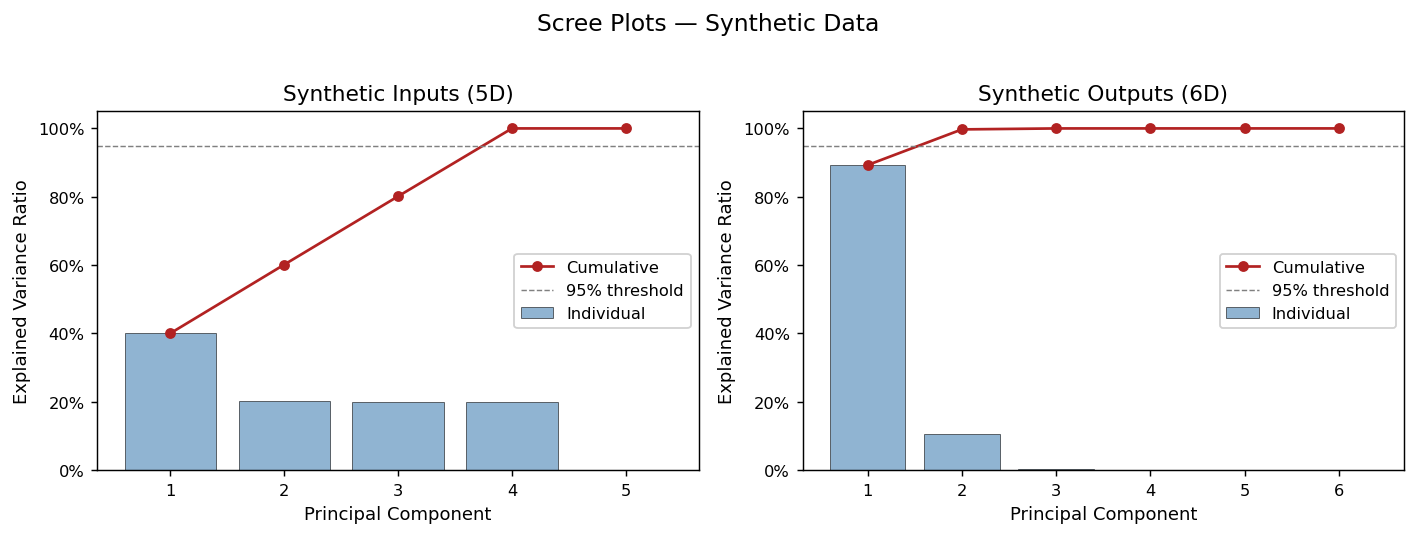

In [30]:
# ---------------------------------------------------------------------------
# Scree plots for synthetic data.
# ---------------------------------------------------------------------------

if HAVE_SYNTH:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_scree(pca_synth_X, "Synthetic Inputs (5D)", ax=axes[0])
    plot_scree(pca_synth_Y, "Synthetic Outputs (6D)", ax=axes[1])
    fig.suptitle("Scree Plots — Synthetic Data", fontsize=13, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print("Skipped — synthetic data not available.")

### Scree Plot Interpretation - Synthetic Data

**Left (Inputs):** The synthetic input scree shows a distinctive "flat plateau"
for PC2–PC4 (all ≈ 20%), in stark contrast to the real data's decaying staircase.
This flatness is the signature of independently, uniformly sampled features:
when [I], T, and t are each drawn from uniform distributions with no
inter-feature correlations, they contribute roughly equal variance. The fact
that PC1 is larger (40%) reflects the [M]/[S] pair counting as one joint
variable with double the "weight" of any single independent feature.

**Right (Outputs):** Even sharper concentration than real data, PC1 alone
captures 89.3%, and the 95% threshold is crossed at PC1 alone. The output
space is essentially 1D (molecular weight) with a small conversion correction
(PC2 = 10.4%). The remaining 4 components carry negligible variance (total
0.29%), which is even less than the real data's 1.03%. This tighter clustering
reflects the smoother, noise-free nature of the synthetic (simulated)
data compared to real experiments.

## 8. Overlay: Real Data in Synthetic PCA Space

This is arguably the most informative visualization. We fit PCA on the
(much larger) synthetic dataset, then project the 57 real points into that
same 2D space. This reveals:

- Whether the real experiments span the synthetic space or cluster in a
  small subregion (which would explain why extrapolation is hard for
  data-only NNs).
- Whether the leave-one-out test reactions truly occupy novel regions
  (supporting the paper's claim that PCINN helps with extrapolation).

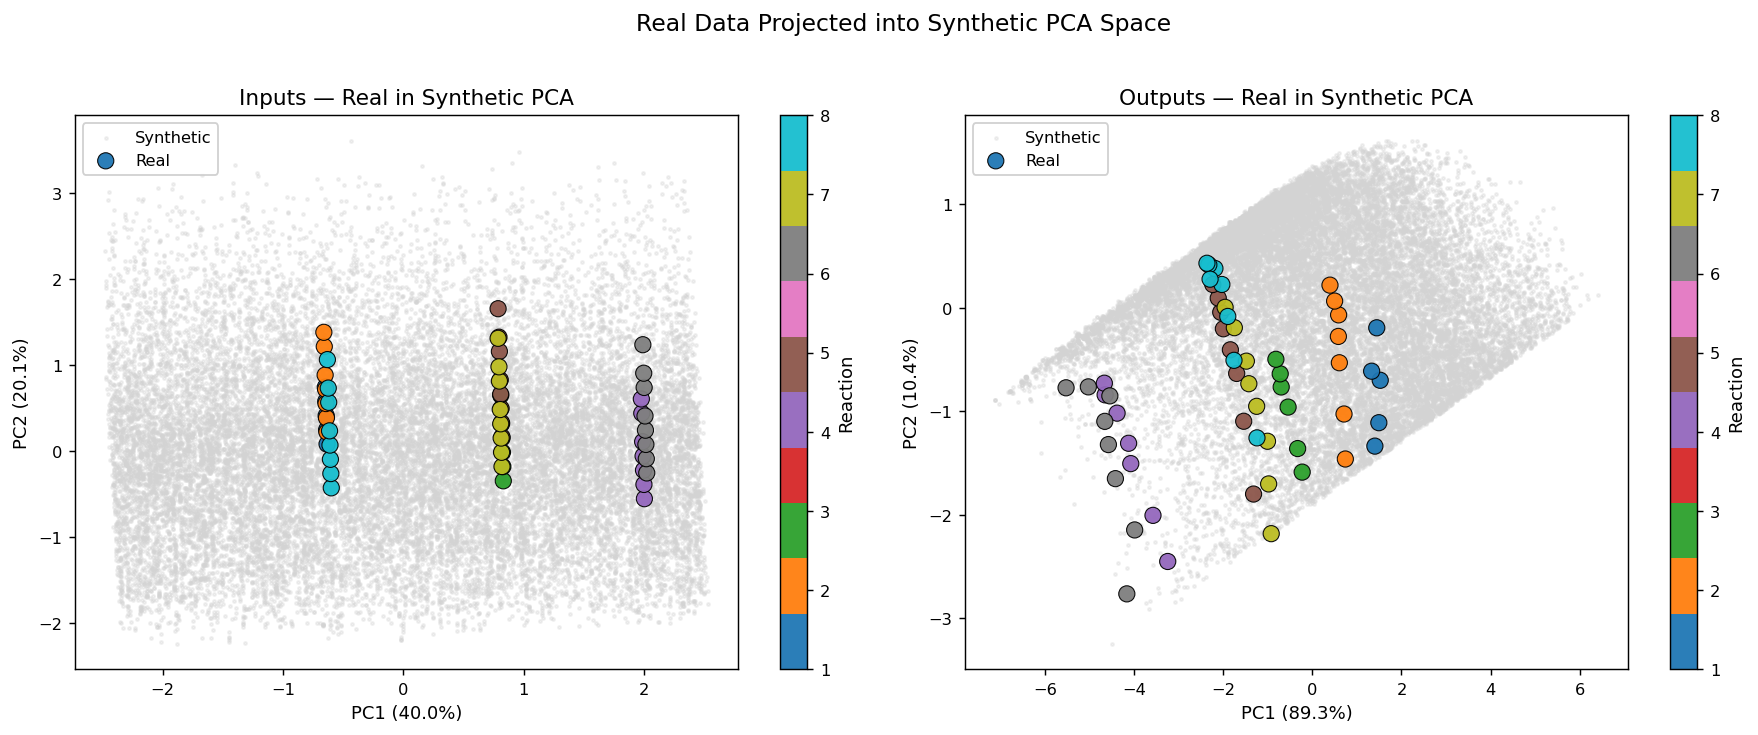

In [31]:
# ---------------------------------------------------------------------------
# Overlay real data points onto the synthetic PCA projection.
# The real data is standardized using the synthetic scaler so the
# coordinate systems align.
# ---------------------------------------------------------------------------


def overlay_scatter(
    synth_std: np.ndarray,
    real_in_synth_space: np.ndarray,
    pca_synth: PCA,
    reactions_arr: np.ndarray,
    title: str,
    ax: Optional[plt.Axes] = None,
) -> None:
    """
    Overlay real data (colored by reaction) on top of the synthetic
    PCA scatter (shown as a gray density cloud).

    Parameters
    ----------
    synth_std : np.ndarray
        Standardized synthetic data.
    real_in_synth_space : np.ndarray
        Real data standardized using the SYNTHETIC scaler.
    pca_synth : PCA
        PCA fitted on the synthetic data.
    reactions_arr : np.ndarray
        Reaction IDs for real data points.
    title : str
        Plot title.
    ax : Axes or None
        Target axes.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 6))

    scores_synth: np.ndarray = pca_synth.transform(synth_std)
    scores_real: np.ndarray = pca_synth.transform(real_in_synth_space)
    var: np.ndarray = pca_synth.explained_variance_ratio_

    # Synthetic as a gray background cloud.
    ax.scatter(
        scores_synth[:, 0], scores_synth[:, 1],
        c="lightgray", s=3, alpha=0.3, rasterized=True, label="Synthetic",
    )

    # Real data overlaid with strong colors.
    sc = ax.scatter(
        scores_real[:, 0], scores_real[:, 1],
        c=reactions_arr, cmap="tab10", edgecolors="k", linewidths=0.6,
        s=80, alpha=0.95, zorder=3, label="Real",
    )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Reaction")

    ax.set_xlabel(f"PC1 ({var[0]:.1%})")
    ax.set_ylabel(f"PC2 ({var[1]:.1%})")
    ax.set_title(title)
    ax.legend(loc="upper left", framealpha=0.9)


if HAVE_SYNTH:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
    overlay_scatter(
        X_synth_std, X_real_in_synth_space, pca_synth_X,
        reactions.values, "Inputs — Real in Synthetic PCA", ax=axes[0],
    )
    overlay_scatter(
        Y_synth_std, Y_real_in_synth_space, pca_synth_Y,
        reactions.values, "Outputs — Real in Synthetic PCA", ax=axes[1],
    )
    fig.suptitle("Real Data Projected into Synthetic PCA Space", fontsize=13, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print("Skipped — synthetic data not available.")

### Overlay Analysis - Critical Findings

**Left panel (Inputs):**

The 57 real data points (colored circles) are embedded within the synthetic
cloud but concentrated in roughly the left-center region along PC1 (values
around −1 to +1.5), while the synthetic cloud spans the full range (−3 to +3).
Since PC1 is the [M]/[S] axis with [M] loading negatively, this means the
real experiments use moderate-to-high monomer concentrations relative to the
full synthetic sampling range, but do not extend to the lowest [M] values
(positive PC1 > 2) or the highest [M] values (negative PC1 < −1.5) that the
synthetic data covers.

Each reaction appears as a distinct vertical column of time-points (since all
samples within one reaction share the same [M], [I], and T, only time varies,
which contributes mainly to PC2). The reactions spread across roughly half
the PC1 range, confirming that while the real experiments are not limited to
a tiny corner, they still leave substantial regions of the input space
uncovered, particularly the extreme low-[M] and high-[M] regions.

This has a direct implication for the PCINN: when one experiment is held out
for cross-validation, the remaining 7 may not cover the held-out reaction's
PC1 position, forcing extrapolation. Jacobian regularization (which samples
gradients across the full synthetic range, including regions with no real
data) addresses this by constraining the model to respect kinetic trends
across the entire input space.

**Right panel (Outputs):**

The real data points (colored circles) sit
within the left-center portion of the synthetic output cloud along PC1
(89.3% of output variance). The real experiments cluster in the negative-to-
moderate PC1 range, corresponding to lower-to-moderate molecular weights.
The synthetic cloud extends further to the right (high PC1), representing
the very high molecular weights achievable at extreme reaction conditions
(high [M], low T, long time) that the 8 real experiments don't cover.

The vertical spread along PC2 (10.4%) captures conversion variation. The real
data points spread from ≈ −3 to +1 on PC2, which is comparable to the
synthetic range, and the real experiments do sample the full conversion range
(from early-time low conversion to near-complete conversion).

## 9. Joint PCA - Combined Input+Output Space

Here we concatenate all 11 features (5 inputs + 6 outputs) into a single
matrix and run PCA. This reveals the joint covariance structure, i.e.,
which combinations of reaction conditions AND outcomes vary together.

In [32]:
# ---------------------------------------------------------------------------
# Joint PCA on the concatenated input + output space (11D).
# ---------------------------------------------------------------------------

ALL_COLS: list[str] = INPUT_COLS + OUTPUT_COLS

# --- Real data (11D) ---
XY_real: np.ndarray = np.hstack([X_real_std, Y_real_std])
pca_real_joint = run_pca(XY_real, ALL_COLS, "PCA — Real Joint (11D)")

# --- Synthetic data (11D), if available ---
if HAVE_SYNTH:
    XY_synth: np.ndarray = np.hstack([X_synth_std, Y_synth_std])
    pca_synth_joint = run_pca(XY_synth, ALL_COLS, "PCA — Synthetic Joint (11D)")

  PCA — Real Joint (11D)
  Samples: 57  |  Features: 11
  PC 1:   65.47% variance  |  cumulative:  65.47%
  PC 2:   18.11% variance  |  cumulative:  83.58%
  PC 3:    9.62% variance  |  cumulative:  93.20%
  PC 4:    5.42% variance  |  cumulative:  98.62%
  PC 5:    0.83% variance  |  cumulative:  99.45%
  PC 6:    0.33% variance  |  cumulative:  99.78%
  PC 7:    0.14% variance  |  cumulative:  99.92%
  PC 8:    0.08% variance  |  cumulative: 100.00%
  PC 9:    0.00% variance  |  cumulative: 100.00%
  PC10:    0.00% variance  |  cumulative: 100.00%
  PC11:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,[M],[S],[I],temp,time,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
PC1,0.3221,-0.3221,-0.1955,-0.1956,-0.1031,-0.1662,0.3665,0.3709,0.3659,0.3667,0.3709
PC2,0.2501,-0.2501,-0.2885,0.3976,0.5345,0.5861,-0.0352,0.0046,0.0557,0.0090,0.0007
PC3,0.0357,-0.0357,-0.5647,0.5876,-0.4896,-0.2598,-0.0461,-0.0605,-0.0098,-0.1291,-0.0590
PC4,0.4485,-0.4485,0.5991,0.2329,-0.3647,0.0983,-0.0731,-0.0766,-0.1573,-0.0187,-0.0752
PC5,-0.2549,0.2549,0.1392,0.1006,-0.4140,0.5963,0.4044,0.1217,0.2679,-0.2083,0.1417
PC6,-0.0935,0.0935,0.3752,0.5066,0.3925,-0.4373,0.3423,0.0795,0.2453,-0.2169,0.0952
PC7,-0.1890,0.1890,0.1963,0.2821,-0.0726,0.0527,-0.5330,0.0973,0.4019,0.5882,0.0354
PC8,0.1434,-0.1434,-0.0317,-0.2333,-0.0121,-0.0448,-0.3786,-0.0523,0.6580,-0.5621,-0.0792
PC9,-0.0358,0.0358,0.0333,0.0579,0.0073,0.0093,-0.3844,0.5512,-0.3329,-0.3088,0.5789
PC10,-0.0000,0.0000,-0.0004,0.0000,-0.0003,0.0005,0.0325,0.7182,-0.0305,-0.0267,-0.6939



  PCA — Synthetic Joint (11D)
  Samples: 24891  |  Features: 11
  PC 1:   60.54% variance  |  cumulative:  60.54%
  PC 2:   17.77% variance  |  cumulative:  78.30%
  PC 3:   10.90% variance  |  cumulative:  89.20%
  PC 4:    9.09% variance  |  cumulative:  98.29%
  PC 5:    1.13% variance  |  cumulative:  99.42%
  PC 6:    0.46% variance  |  cumulative:  99.88%
  PC 7:    0.11% variance  |  cumulative: 100.00%
  PC 8:    0.00% variance  |  cumulative: 100.00%
  PC 9:    0.00% variance  |  cumulative: 100.00%
  PC10:    0.00% variance  |  cumulative: 100.00%
  PC11:    0.00% variance  |  cumulative: 100.00%

  Loadings (component × feature):


,[M],[S],[I],temp,time,X,log10_Mn,log10_Mw,log10_Mz,log10_Mzplus1,log10_Mv
PC1,0.2418,-0.2418,-0.1498,-0.2467,-0.0673,-0.2375,0.3823,0.3860,0.3846,0.3830,0.3860
PC2,-0.5139,0.5139,-0.1126,-0.3030,-0.3549,-0.4807,0.0834,0.0140,-0.0242,-0.0451,0.0211
PC3,-0.2723,0.2723,-0.3215,-0.2926,0.7444,0.2858,0.0185,0.0641,0.0899,0.1044,0.0593
PC4,0.0088,-0.0088,0.8322,-0.5303,0.1546,-0.0031,-0.0373,-0.0001,0.0159,0.0228,-0.0034
PC5,-0.0726,0.0726,-0.0951,-0.3098,-0.5338,0.7656,0.0436,0.0276,0.0550,0.0844,0.0248
PC6,-0.3108,0.3108,0.3994,0.6192,0.0202,0.1904,0.2215,0.2150,0.2061,0.2059,0.2168
PC7,0.0355,-0.0355,0.0217,-0.0293,0.0783,0.0795,0.8182,-0.0456,-0.3529,-0.4324,0.0237
PC8,-0.0036,0.0036,0.0043,0.0161,0.0058,-0.0454,0.3443,-0.4808,0.1000,0.5816,-0.5474
PC9,-0.0001,0.0001,0.0009,-0.0002,0.0002,0.0067,0.0779,-0.0446,0.7951,-0.5125,-0.3117
PC10,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0001,0.0100,0.7513,-0.1761,0.0487,-0.6341


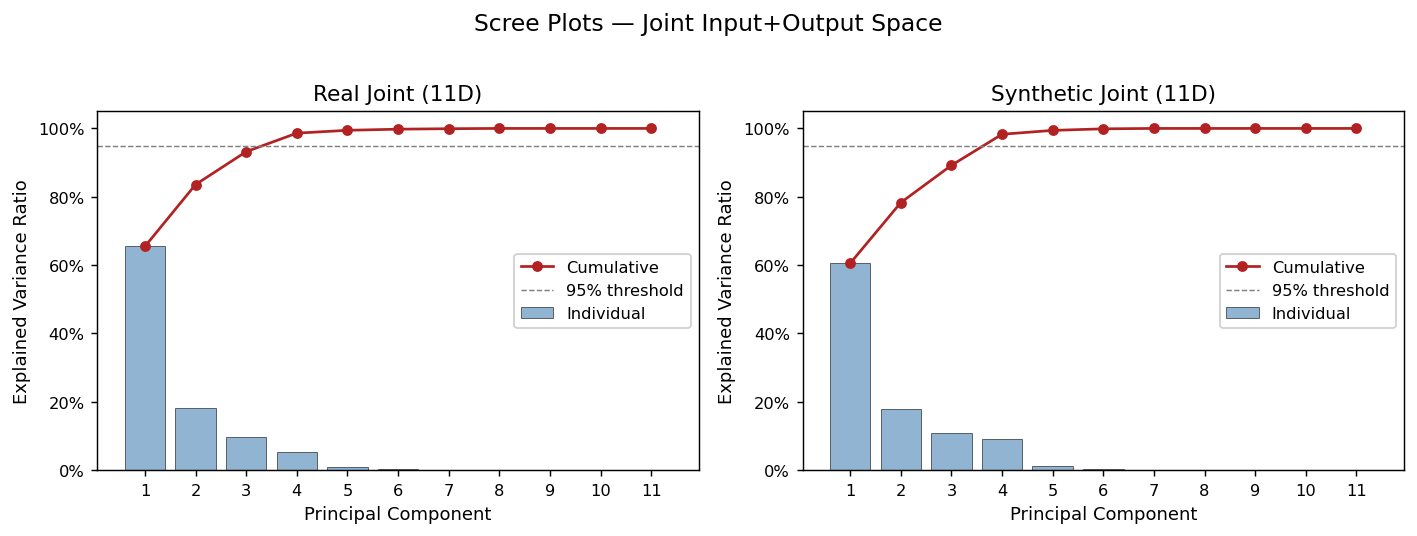

In [33]:
# ---------------------------------------------------------------------------
# Scree comparison: real vs synthetic joint PCA.
# ---------------------------------------------------------------------------

if HAVE_SYNTH:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    plot_scree(pca_real_joint, "Real Joint (11D)", ax=axes[0])
    plot_scree(pca_synth_joint, "Synthetic Joint (11D)", ax=axes[1])
    fig.suptitle("Scree Plots — Joint Input+Output Space", fontsize=13, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(5.5, 4))
    plot_scree(pca_real_joint, "Real Joint (11D)", ax=ax)
    fig.tight_layout()
    plt.show()

### Joint PCA Scree - Real vs. Synthetic

**Real Joint (11D):** The joint space is remarkably compressible: 4 PCs
capture 98.6% of variance. The dominant PC1 (65.5%) combines the MW-scale
output component with the monomer concentration input component. This means
the single strongest axis of variation in the entire dataset is "reactions
with more monomer produce higher molecular weights": a fundamental
chemical relationship. PC2 (18.1%) captures temperature/conversion dynamics,
and PC3–PC4 capture residual input variations.

The 11D space collapses to ~4 effective dimensions because: (a) [M] and [S]
are redundant (−1 dim), (b) the 5 MW moments are nearly co-linear (−4 dims),
leaving 11 − 1 − 4 = 6 nominally independent dimensions, of which only ~4
carry meaningful variance.

**Synthetic Joint (11D):** Variance is more concentrated than expected:
4 PCs capture 98.3% (vs. 98.6% for real), and the decay pattern
(PC1=60.5%, PC2=17.8%, PC3=10.9%, PC4=9.1%) is quite similar to the real
data. The synthetic PC1 is higher than the pre-fix value (60.5% vs. the
buggy 57.6%), because the log₁₀ transform compresses the MW range into a
scale consistent with the other features, concentrating more variance
into the leading component. The 95% threshold is crossed at PC4 for both
datasets, indicating the same ~4 effective dimensions in both the real and
synthetic joint spaces.

## 10. Pairwise PC Scatter Matrix — Real Data (First 4 PCs)

A scatter matrix of the first 4 principal components of the joint (11D)
space gives a richer view than just PC1 vs PC2.

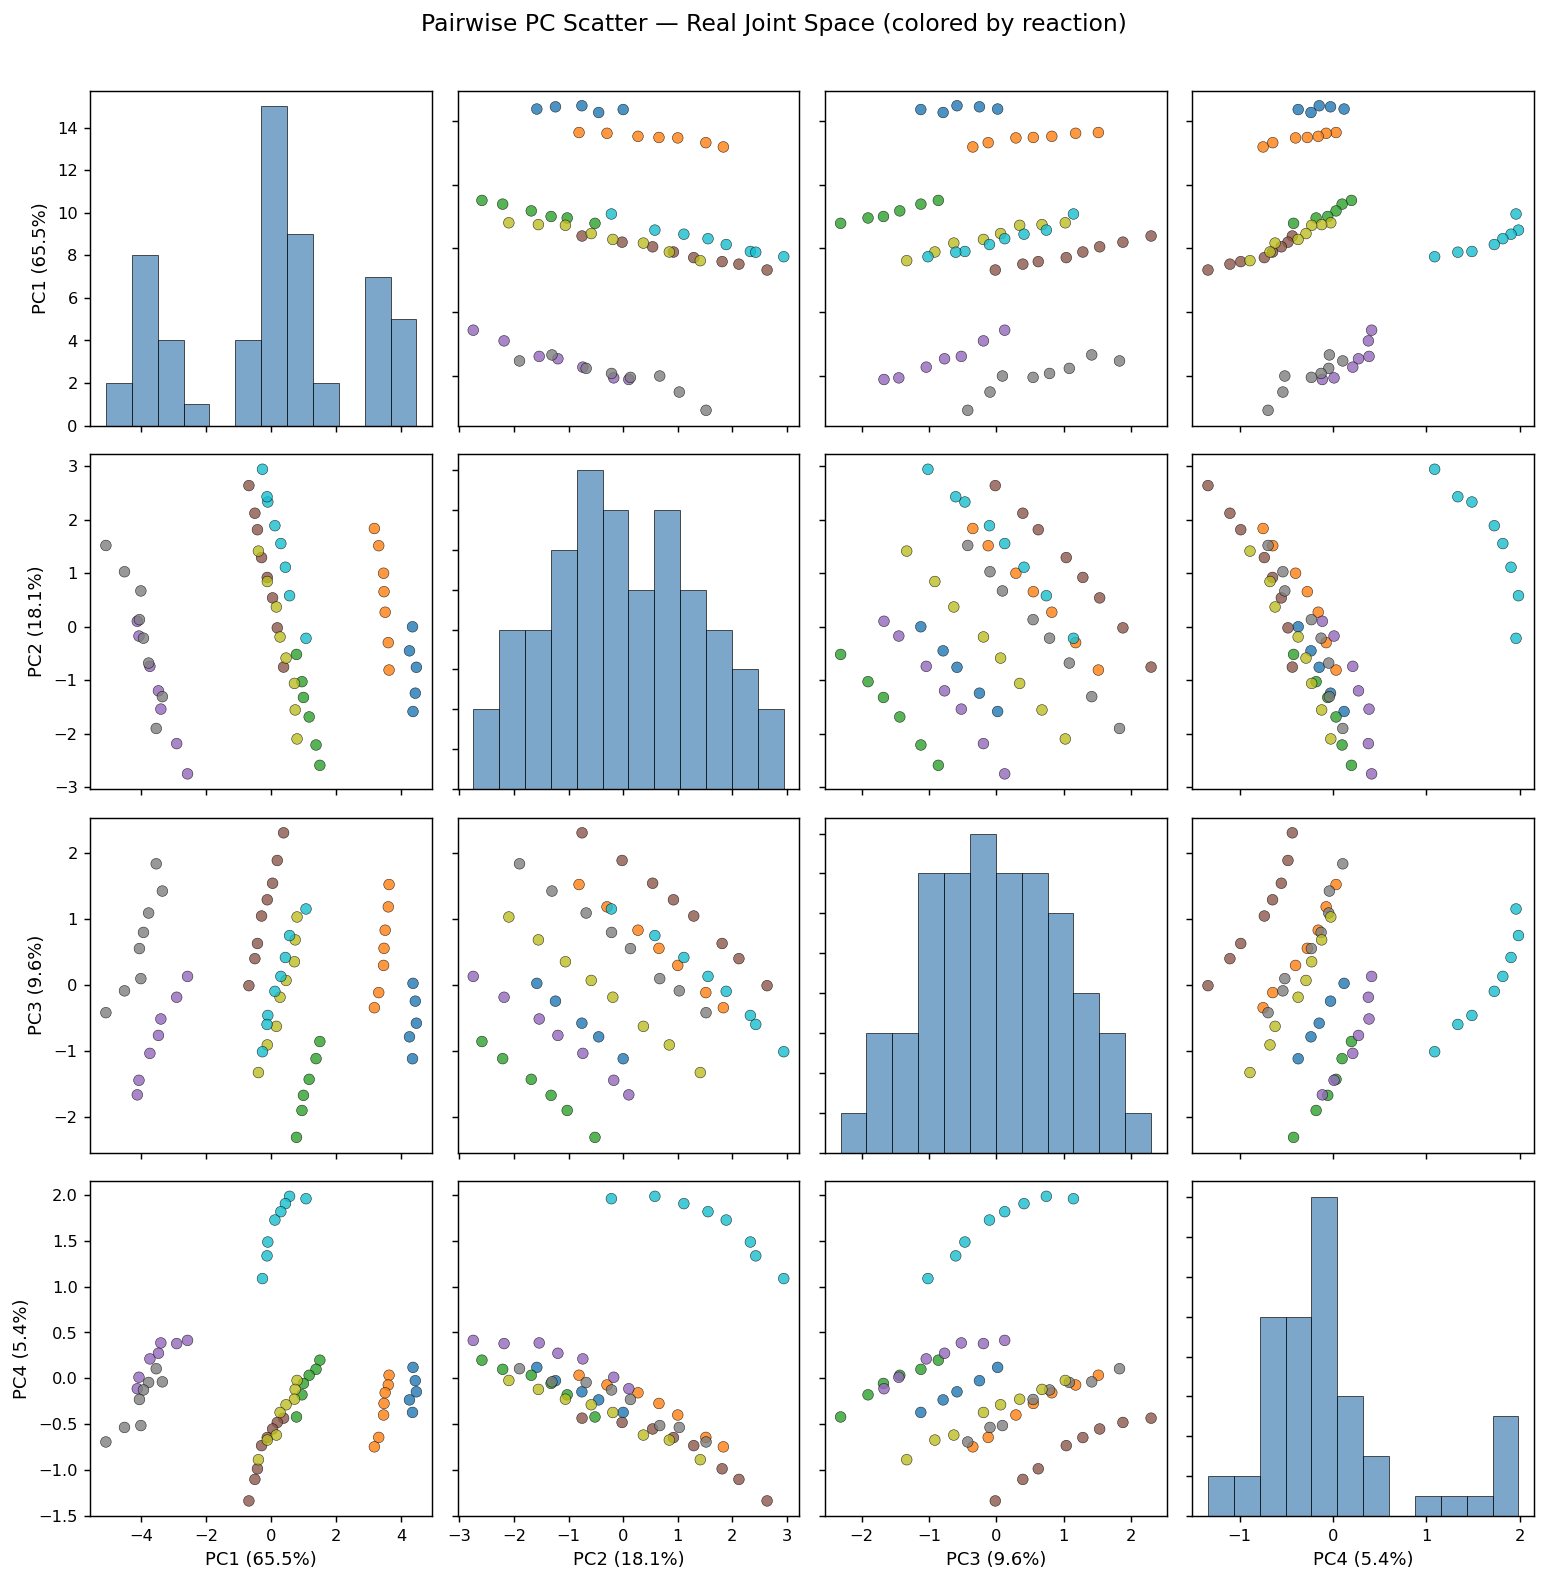

In [34]:
# ---------------------------------------------------------------------------
# Pairwise scatter matrix of the first 4 joint PCs (real data).
# ---------------------------------------------------------------------------

N_PC_PAIRS: int = 4

scores_joint_real: np.ndarray = pca_real_joint.transform(XY_real)[:, :N_PC_PAIRS]
var_joint_real: np.ndarray = pca_real_joint.explained_variance_ratio_[:N_PC_PAIRS]

fig, axes = plt.subplots(N_PC_PAIRS, N_PC_PAIRS, figsize=(12, 12))
for i in range(N_PC_PAIRS):
    for j in range(N_PC_PAIRS):
        ax = axes[i, j]
        if i == j:
            # Diagonal: histogram of that PC.
            ax.hist(scores_joint_real[:, i], bins=12, color="steelblue",
                    edgecolor="k", lw=0.5, alpha=0.7)
            ax.set_ylabel("Count" if j == 0 else "")
        else:
            ax.scatter(
                scores_joint_real[:, j], scores_joint_real[:, i],
                c=reactions.values, cmap="tab10", edgecolors="k",
                linewidths=0.3, s=35, alpha=0.8,
            )
        if i == N_PC_PAIRS - 1:
            ax.set_xlabel(f"PC{j+1} ({var_joint_real[j]:.1%})")
        else:
            ax.set_xticklabels([])
        if j == 0:
            ax.set_ylabel(f"PC{i+1} ({var_joint_real[i]:.1%})")
        else:
            ax.set_yticklabels([])

fig.suptitle("Pairwise PC Scatter — Real Joint Space (colored by reaction)",
             fontsize=13, y=1.01)
fig.tight_layout()
plt.show()

### Pairwise Scatter Matrix Interpretation

This 4×4 scatter matrix shows the first 4 joint PCs (covering 98.6% of
variance). Key observations from the off-diagonal scatters:

**PC1 vs PC2 (top row, second column):** Reactions separate into clear
horizontal bands along PC1 (molecular-weight/monomer axis). Within each band,
points spread vertically along PC2 (conversion/temperature axis). This confirms
that monomer loading and reaction progress are the two dominant independent
axes of variation in the full input+output space.

**PC3 histogram (diagonal):** Shows a bimodal distribution: there are two
clusters of reactions in the PC3 direction, corresponding to different
initiator/temperature combinations. The two modes correspond roughly to
60–70 °C reactions vs. 80 °C reactions.

**PC1 vs PC4 (bottom-left):** R8 (cyan, high positive PC4) is clearly
separated from other reactions. This is significant because R8 is the default
held-out reaction in the single-fold PCINN training. This plot shows it
occupies a somewhat unique position in the joint space, though not the most
extreme (R1 is farther in PC1).

**PC4 histogram (diagonal):** A multimodal distribution with clear gaps,
reflecting the limited number of distinct [I] values across the 8 reactions.
This discreteness of the experimental design contributes to the extrapolation
challenge.

## 11. Per-Reaction Leave-One-Out Distance Analysis

For each reaction held out in the leave-one-experiment-out CV, we compute
the Mahalanobis distance from the held-out reaction's centroid to the
training set centroid in PCA space. Reactions that are farther away
(in terms of principal components) should be harder to predict: this
is exactly the scenario where PCINN's Jacobian regularization helps most.

Leave-one-out centroid distances in first 4 joint PCs:
(Larger distance → harder extrapolation → more benefit from PCINN)



,Reaction,PC_Distance,N_test
0,1,4.922390,5
1,6,4.750636,8
2,4,4.277496,7
3,2,4.068716,7
4,3,2.764679,6
5,8,2.687012,8
6,5,2.039595,8
7,7,0.750591,8


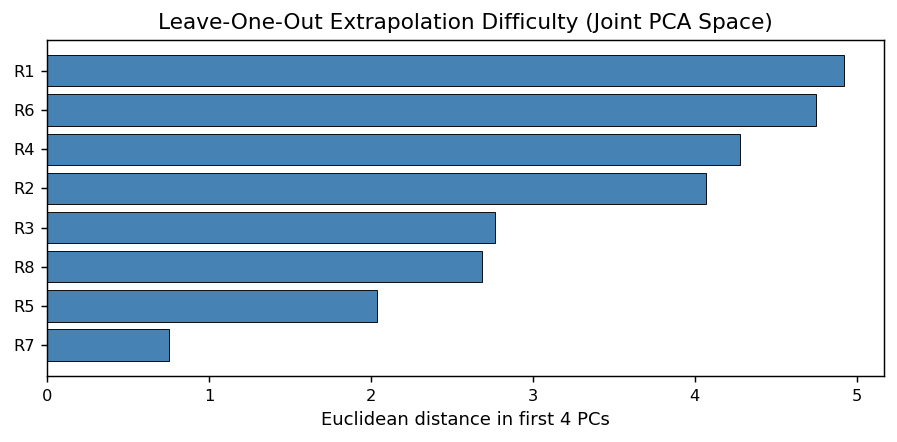

In [35]:
# ---------------------------------------------------------------------------
# Per-reaction leave-one-out analysis in joint PCA space.
# We compute Euclidean distance between each held-out reaction's centroid
# and the training set centroid in the first K PCs.
# ---------------------------------------------------------------------------

K_PCS: int = min(4, pca_real_joint.n_components_)

scores_all: np.ndarray = pca_real_joint.transform(XY_real)[:, :K_PCS]
reaction_ids: np.ndarray = reactions.values
unique_rxns: np.ndarray = np.sort(np.unique(reaction_ids))

distances: list[tuple[int, float, int]] = []

for rxn in unique_rxns:
    # Boolean masks for train vs test.
    test_mask: np.ndarray = reaction_ids == rxn
    train_mask: np.ndarray = ~test_mask

    # Centroids in PC space.
    centroid_train: np.ndarray = scores_all[train_mask].mean(axis=0)
    centroid_test: np.ndarray = scores_all[test_mask].mean(axis=0)

    # Euclidean distance between centroids.
    dist: float = float(np.linalg.norm(centroid_test - centroid_train))
    n_test: int = int(test_mask.sum())
    distances.append((int(rxn), dist, n_test))

dist_df: pd.DataFrame = pd.DataFrame(
    distances, columns=["Reaction", "PC_Distance", "N_test"]
).sort_values("PC_Distance", ascending=False)

print(f"Leave-one-out centroid distances in first {K_PCS} joint PCs:")
print(f"(Larger distance → harder extrapolation → more benefit from PCINN)\n")
display(dist_df.reset_index(drop=True))

# Bar chart.
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.barh(
    [f"R{r}" for r in dist_df["Reaction"]],
    dist_df["PC_Distance"],
    color="steelblue", edgecolor="k", lw=0.5,
)
ax.set_xlabel(f"Euclidean distance in first {K_PCS} PCs")
ax.set_title("Leave-One-Out Extrapolation Difficulty (Joint PCA Space)")
ax.invert_yaxis()
fig.tight_layout()
plt.show()

### Leave-One-Out Distance - Interpretation

This analysis quantifies *how different* each held-out reaction is from the
training set centroid in the first 4 joint PCs. The ranking reveals which
folds should be hardest for data-only NNs and where PCINN's Jacobian
regularization should help most:

**Hardest folds (largest distance):**

- **R1** (distance = 4.92): 60 °C, highest monomer loading (49.9 g),
  moderate [I]. This is the coldest reaction with the most monomer: an
  extreme corner of the experimental design.
- **R6** (distance = 4.75): 80 °C, lowest monomer loading (10.0 g),
  moderate [I]. This is the hottest reaction with very little monomer: the
  the opposite extreme from R1.
- **R4** (distance = 4.28): 70 °C, very low monomer (10.3 g), highest [I].
  Another extreme in the monomer/initiator subspace.

**Easiest fold (smallest distance):**

- **R7** (distance = 0.75): 70 °C, medium monomer (25.1 g), moderate [I].
  This reaction sits near the centroid of the design: removing it barely
  shifts the training set distribution.

**Cross-reference with the paper's Table 4:** The paper reports per-fold test
errors. If the PCINN is working as intended, the reactions with the largest
PCA distances (R1, R6, R4) should show the biggest improvement from PCINN
over the baseline NN, because these are the folds where the baseline NN must
extrapolate the most. R7 should show the smallest improvement, since even
a data-only NN can interpolate well when the test point is near the training
centroid.

## 12. Feature Correlation Heatmaps

Pearson correlation matrices for inputs and outputs (real data) give
a complementary view to PCA: showing which raw features are linearly
related before any dimensionality reduction.

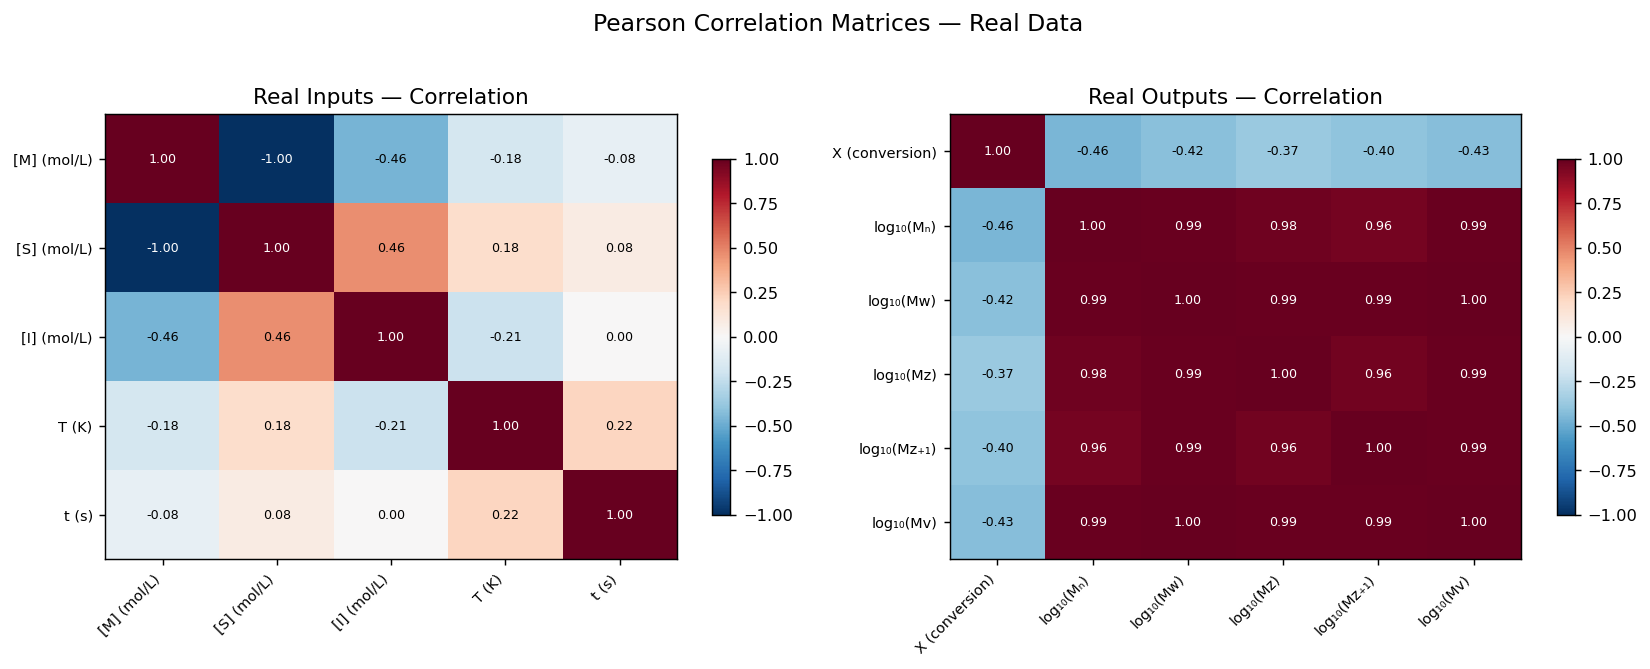

In [36]:
# ---------------------------------------------------------------------------
# Correlation heatmaps for real data (inputs and outputs separately).
# ---------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, df, cols, title in [
    (axes[0], X_real, INPUT_LABELS, "Real Inputs — Correlation"),
    (axes[1], Y_real, OUTPUT_LABELS, "Real Outputs — Correlation"),
]:
    corr: pd.DataFrame = df.copy()
    corr.columns = cols
    corr_matrix: pd.DataFrame = corr.corr()

    im = ax.imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)
    ax.set_title(title)

    # Annotate cells with correlation values.
    for i in range(len(cols)):
        for j in range(len(cols)):
            val: float = corr_matrix.values[i, j]
            color: str = "white" if abs(val) > 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    fontsize=7, color=color)

    plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle("Pearson Correlation Matrices — Real Data", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()

### Correlation Heatmap Analysis

**Left (Input Correlations):**

The most striking feature is the **[M] and [S] correlation of r = −1.00:**
perfect anti-correlation, confirming the [S] = 10 − [M] constraint. This is
why PCA identifies one exactly-zero eigenvalue (PC5).

The second strongest input correlation is **[M] and [I] at r = −0.46:**
a moderate anti-correlation. In the experimental design, higher monomer
reactions tend to use less initiator (and vice versa). This is a design
choice, not a physical constraint, but it reduces the effective dimensionality
of the input space further.

Temperature and time are only weakly correlated (r = +0.22), and [I] vs. T
shows r = −0.21. The near-zero correlations between time and everything else
(r ≈ 0.00–0.08) confirm that sampling times are independent of the initial
reaction conditions, as expected, since time points are taken within each
reaction regardless of the conditions.

**Right (Output Correlations):**

All MW moment pairs show **r = 0.96–0.99:** near-perfect positive
correlations. This is the source of the 85.7% PC1 dominance: the moments are
derived from the same MWD and move in lockstep. The slightly lower correlations
involving Mz+1 (r = 0.96) indicate that higher-order moments are marginally
more sensitive to distribution tail behavior.

Conversion (X) is moderately anti-correlated with all MW moments
(r ≈ −0.37 to −0.46). This reflects the kinetics: as conversion increases,
chain transfer and termination rates increase, producing shorter chains on
average. The anti-correlation is strongest for Mn (r = −0.46) and weakest
for Mz (r = −0.37), because higher-order moments weight the heavier chains
produced early in the reaction more heavily.

## 13. Summary & Key Takeaways

### Effective Dimensionality

| Space | Nominal Dims | 95% Variance | 99% Variance | Explanation |
|-------|:---:|:---:|:---:|-------------|
| Real Inputs | 5 | 3 PCs (90.3%) | 4 PCs (100%) | [S] = 10−[M] eliminates 1 dim; remaining 4 carry unequal weight |
| Real Outputs | 6 | 1 PC (85.7%) | 2 PCs (99.0%) | 5 MW moments are near-co-linear; conversion is the only independent axis |
| Real Joint | 11 | 3 PCs (93.2%) | 4 PCs (98.6%) | Massive redundancy: 11D collapses to ~4 effective dims |
| Synth Inputs | 5 | 4 PCs (100%) | 4 PCs (100%) | Same [M]/[S] constraint; but PC2–4 are evenly distributed (~20% each) |
| Synth Outputs | 6 | 1 PC (89.3%) | 2 PCs (99.7%) | Same 2D structure as real: fundamental to the polymerization chemistry |
| Synth Joint | 11 | 4 PCs (98.3%) | 5 PCs (99.4%) | Very similar dimensionality to real; log₁₀ scaling aligns the two spaces |

### Most Important Features

**Inputs:** Monomer concentration [M] (equivalently [S]) is the single most
important feature in both datasets, dominating PC1 in every analysis.
Temperature is consistently the second most important, followed by reaction
time. Initiator concentration [I] contributes the least independent variance,
partly because it co-varies with [M] in the real experimental design (r = −0.46).

**Outputs:** The molecular weight scale (a shared axis on which all 5 MW moments
move together) is by far the dominant output dimension. Conversion is the
only other significant independent axis. The five individual MW moments
(Mn, Mw, Mz, Mz+1, Mv) carry almost no independent information relative
to each other, in principle, predicting any one of them accurately would
constrain the other four to r > 0.96.

### Real vs. Synthetic - Convergence and Divergence

**Where they converge (structural similarities):**

Both datasets have exactly 4 effective input dimensions (PC5 = 0% in both)
due to the universal [S] = 10−[M] constraint. Both outputs are essentially
2D (one MW axis, one conversion axis) with nearly identical loading vectors
(PC1 MW loadings ≈ 0.43, PC2 conversion loading ≈ 0.94–0.97 in both). This
2D output structure is a fundamental property of free-radical polymerization,
not an artifact of the experimental design. The [M]/[S] pair dominates PC1
in both, with loadings at ±0.71. The joint PCA dimensionality is also
remarkably consistent: both datasets require ~4 PCs for 98%+ variance.

**Where they diverge (distribution differences):**

The real data has uneven PC1–PC4 input variance (47%, 26%, 17%, 10%)
reflecting a constrained experimental design. Synthetic data has much flatter
PC2–PC4 (20%, 20%, 20%) from uniform random sampling. This means the real
experiments over-represent monomer concentration variation and under-represent
initiator and temperature variation.

The overlay plot shows the real experiments occupy roughly the center-left
portion of the synthetic input cloud along PC1, covering perhaps half the
full synthetic range. The real data does not extend to the extreme low-[M]
or extreme high-[M] regions of the synthetic space. In the output overlay,
the real data clusters in the lower-to-moderate MW region, not reaching the
highest molecular weights achievable at extreme synthetic conditions.

### Hardest Reactions for Leave-One-Out Prediction

R1 (60 °C, 49.9 g monomer) and R6 (80 °C, 10.0 g monomer) are the two
most isolated reactions in joint PCA space, with PC distances of 4.92 and
4.75 respectively. These represent opposite extremes of the monomer×temperature
design space and should show the largest baseline NN test errors and the
greatest benefit from PCINN Jacobian regularization. R7 (70 °C, 25.1 g
monomer) is the easiest fold (distance = 0.75), sitting near the design
centroid.

### Implications for PCINN Training

First, **Jacobian regularization is critical because of the coverage gap.**
The overlay shows that real experiments cover roughly half of the synthetic
input space, leaving the extreme ends uncovered. The PCINN's Jacobian
sampling spans the full synthetic range (T ∈ [50, 90] °C,
[M] ∈ [0.5, 5.0] mol/L), forcing the learned model to respect kinetic
trends beyond the training data's boundaries.

Second, **the output's low dimensionality is good news.** With only ~2 effective
output dimensions, the model doesn't need to learn 6 independent mappings,
it just needs to get the molecular weight scale and conversion right, and
the individual moments will follow.

Third, **[M] variation dominates the learning problem.** Since nearly half of all
input variance (47%) comes from [M]/[S], and the real experiments don't cover
the full [M] range of the synthetic space, the model's ability to generalize
across monomer concentrations is the key challenge. The Jacobian loss addresses
this directly by enforcing correct ∂y/∂[M] gradients at [M] values outside
the training data.